In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
sys.path.append("../../")
import data_loading as dl

from microfit import run_plotter as rp
from microfit import histogram as hist
from microfit import selections as sel
from microfit.run_plotter import RunHistPlotter
from microfit.histogram import Binning, MultiChannelBinning
import make_detsys as detsys

### Load the Data ###

In [3]:
RUN = ["1","2","3","4b","4c","4d","5"]
binning_def = ("reco_e", 10, (0.15, 1.55), "reconstructed energy [GeV]")
binning = Binning.from_config(*binning_def)
selection = "NPBDT"
preselection = "NP"

In [16]:
rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=True,
    blinded=True,
    enable_cache=True,
    numupresel=False,
    loadnumuvariables=False,
    use_bdt=True,
    load_numu_tki=False,
    use_new_signal_model=True
)

Loading run 1
Loading run 2
Loading run 3
Loading run 4b
Loading run 4c
Loading run 4d
Loading run 5


In [5]:
from microfit import selections as sel
selection_query = sel.get_selection_query(selection,preselection)
selected_dirt = rundata["drt"].query(selection_query,engine="python")
print(selected_dirt[["reco_e","weights"]])
print(sum(selected_dirt["weights"]))

         reco_e   weights
entry                    
11     0.228978  0.000343
0.00034324839361943305


### Calculate the Detector Uncertainties on the Nue/NCpi0 Background ###

Loading detvar data for run 1 and variation cv
Loading detvar data for run 2 and variation cv
Loading detvar data for run 3 and variation cv
Loading detvar data for run 4b and variation cv
Loading detvar data for run 4c and variation cv
Loading detvar data for run 4d and variation cv
Loading detvar data for run 5 and variation cv
Loading detvar data for run 1 and variation lydown
LY Down uncertainties is not used in run 1, loading CV sample as a dummy
Loading detvar data for run 2 and variation lydown
Loading detvar data for run 3 and variation lydown
Loading detvar data for run 4b and variation lydown
Loading detvar data for run 4c and variation lydown
Loading detvar data for run 4d and variation lydown
Loading detvar data for run 5 and variation lydown
Loading detvar data for run 1 and variation lyatt
Loading detvar data for run 2 and variation lyatt
Loading detvar data for run 3 and variation lyatt
Loading detvar data for run 4b and variation lyatt
Loading detvar data for run 4c and

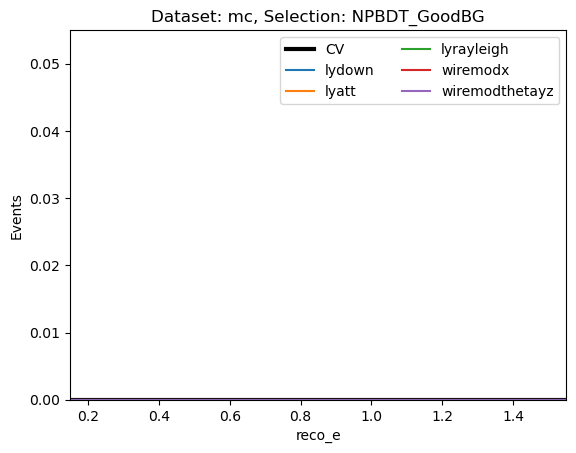

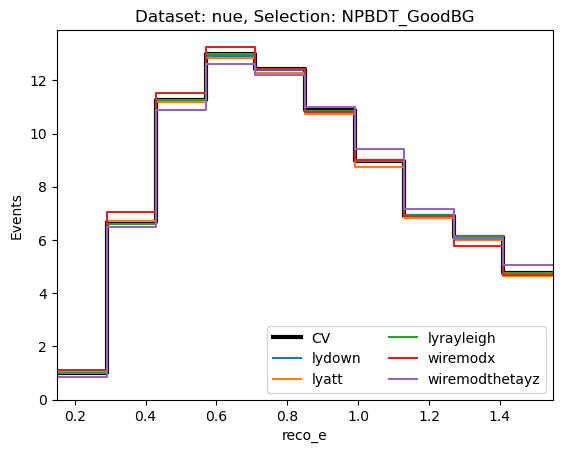

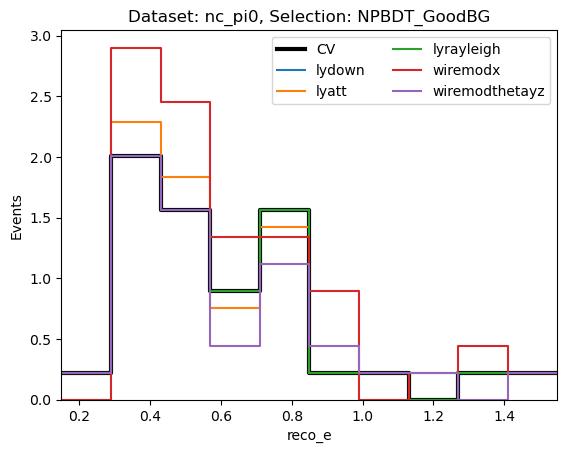

In [6]:
good_bg_detvars = detsys.make_variations(
    RUN,
    "bnb",
    selection+"_GoodBG",
    preselection,
    binning,
    make_plots=True,
    truth_filtered_sets=["nue","nc_pi0"],
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=True,
    blinded=True,
    enable_cache=True,
    numupresel=False,
    loadnumuvariables=False,
    use_bdt=True,
    load_numu_tki=False
)

### Draw the Prediction with All Uncertainties Except Detsys on Misc Background ###

In [7]:
signal_generator = hist.RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    uncertainty_defaults={"include_multisim_errors": True,"include_unisim_errors": True},
    detvar_data=good_bg_detvars
)

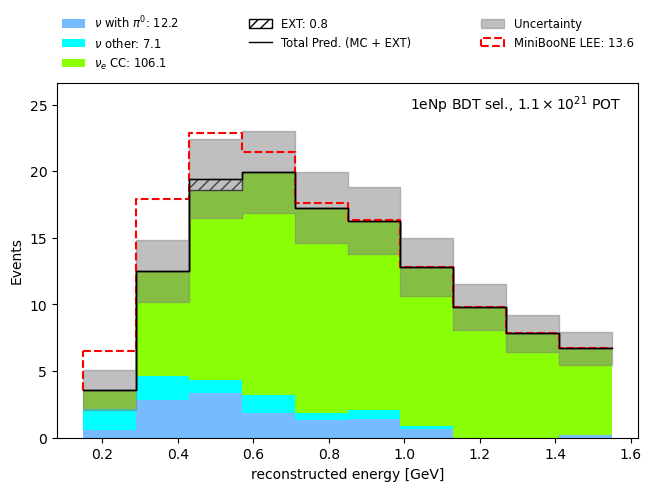

In [8]:
ax = RunHistPlotter(signal_generator).plot(
    category_column="paper_category", include_multisim_errors=True, show_data_mc_ratio=False, add_ext_error_floor=False,
    channel=selection,add_precomputed_detsys=True,show_chi_square=False
)

[[ 4.66679611  2.86070401  2.55169916  1.45673037  0.3027899  -0.13051791
  -0.45854555 -0.55393488 -0.3056572  -0.33191487]
 [ 2.86070401  8.92934933  8.25097262  6.969359    4.25529307  4.56953799
   2.85994119  2.62040365  1.83649245  1.48370613]
 [ 2.55169916  8.25097262 11.14282315  8.96183713  6.05445455  5.97934068
   3.91270556  3.39937266  2.63270102  2.04049567]
 [ 1.45673037  6.969359    8.96183713 10.57200557  7.28635313  6.31670702
   4.76803017  3.88730406  3.55111909  2.56562129]
 [ 0.3027899   4.25529307  6.05445455  7.28635313  7.28400546  5.17284275
   4.51197676  3.42483554  3.36983567  2.45691112]
 [-0.13051791  4.56953799  5.97934068  6.31670702  5.17284275  6.22331632
   4.47677091  3.78454266  2.70356282  2.50088059]
 [-0.45854555  2.85994119  3.91270556  4.76803017  4.51197676  4.47677091
   4.63730694  3.4004243   2.57377951  2.40011837]
 [-0.55393488  2.62040365  3.39937266  3.88730406  3.42483554  3.78454266
   3.4004243   2.96939044  2.00869118  1.92723717]


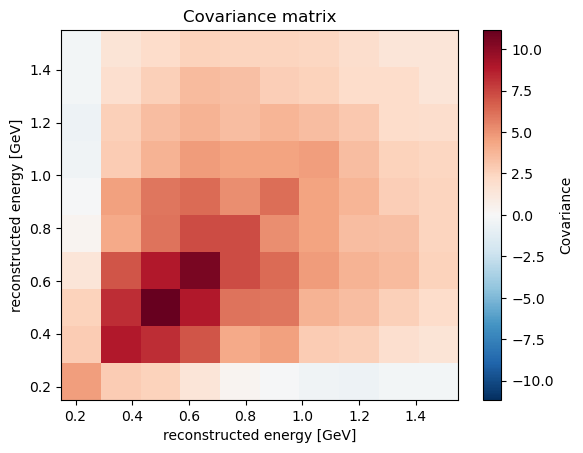

In [9]:
pred_hist_good = signal_generator.get_total_prediction(include_multisim_errors=True,add_precomputed_detsys=True)
pred_hist_good.draw_covariance_matrix(as_correlation=False)
good_bg_cov_matrix = pred_hist_good.covariance_matrix

print(pred_hist_good.covariance_matrix)

### Estimate the Covariance When the Data Stats Are Included ###

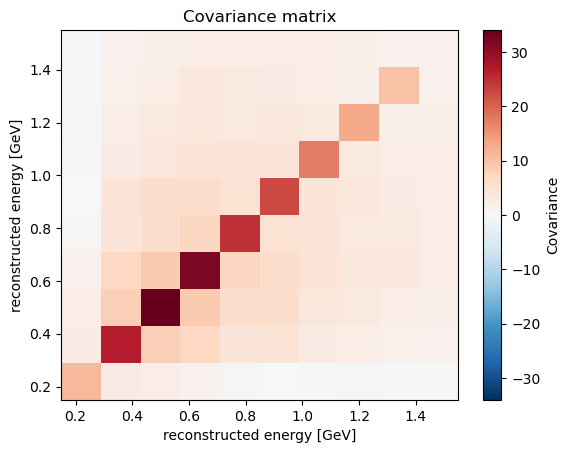

In [10]:
pred_hist = signal_generator.get_total_prediction(include_multisim_errors=True,add_precomputed_detsys=True)
nominal_values = pred_hist.bin_counts
good_bg_cov_matrix = pred_hist.covariance_matrix

extra_data_cov_matrix = np.zeros(shape=(binning.n_bins,binning.n_bins))
for i in range(0,binning.n_bins-1):
    extra_data_cov_matrix[i][i] = nominal_values[i]

pred_hist.covariance_matrix = np.add(good_bg_cov_matrix,extra_data_cov_matrix)
    
pred_hist.draw_covariance_matrix(as_correlation=False)
good_bg_cov_matrix = pred_hist_good.covariance_matrix

### Calculate the Misc Background and Calculate the Covariance Matrix Needed to Apply Uncertainty ###

In [11]:
signal_generator_misc_bg = hist.RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection+"_MiscBG",
    preselection=preselection,
    uncertainty_defaults={"include_multisim_errors": False,"include_unisim_errors": False},
)

../../microfit/run_plotter.py:117: UserWarning: No signal category found in the MC hists. Not separating signal.
  warnings.warn("No signal category found in the MC hists. Not separating signal.")


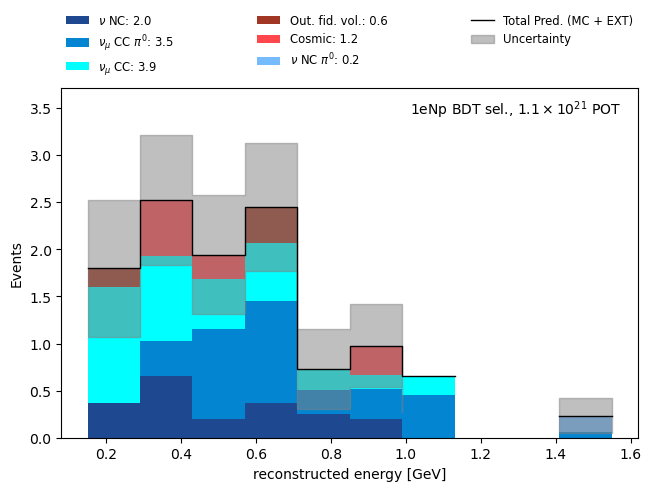

In [12]:
ax = RunHistPlotter(signal_generator_misc_bg).plot(
    category_column="category", include_multisim_errors=False, show_data_mc_ratio=False, add_ext_error_floor=False,
    channel=selection,add_precomputed_detsys=False,show_chi_square=False
)

<AxesSubplot:title={'center':'Covariance matrix'}, xlabel='reconstructed energy [GeV]', ylabel='reconstructed energy [GeV]'>

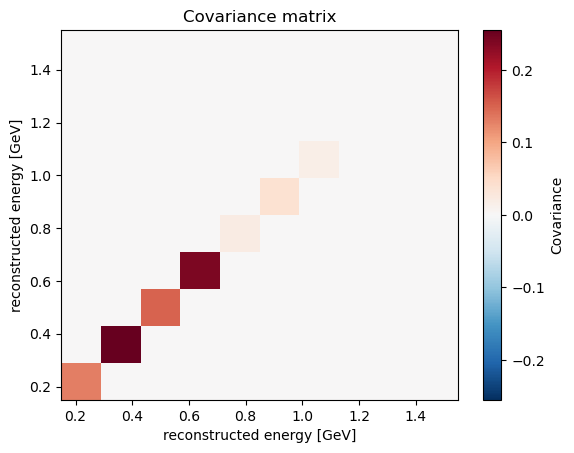

In [13]:
import matplotlib.pyplot as plt

extra_frac_unc = 0.2

pred_hist_misc = signal_generator_misc_bg.get_total_prediction(include_multisim_errors=False,add_precomputed_detsys=False)
nominal_values = pred_hist_misc.bin_counts

extra_cov = np.zeros(shape=(binning.n_bins,binning.n_bins))
for i in range(0,binning.n_bins-1):
    extra_cov[i][i] = extra_frac_unc**2*nominal_values[i]**2

pred_hist_misc.covariance_matrix = extra_cov
    
pred_hist_misc.draw_covariance_matrix(as_correlation=False)    

In [14]:
signal_generator = hist.RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    uncertainty_defaults={"include_multisim_errors": True,"include_unisim_errors": True},
    detvar_data=good_bg_detvars,
    extra_mc_covariance=extra_cov
)

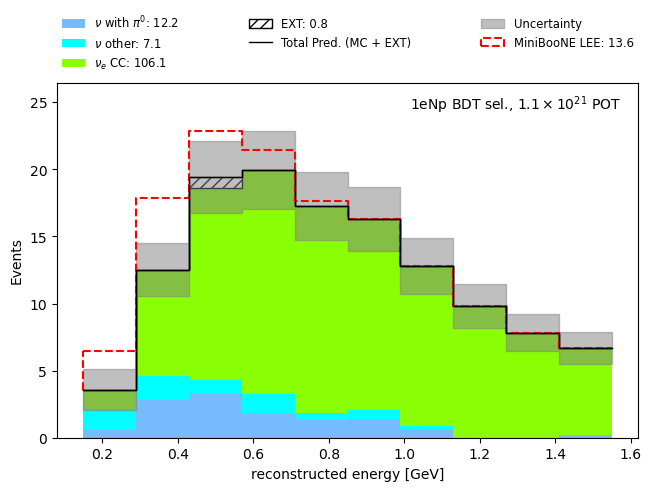

In [15]:
ax = RunHistPlotter(signal_generator).plot(
    category_column="paper_category", include_multisim_errors=True, show_data_mc_ratio=False, add_ext_error_floor=False,
    channel=selection,add_precomputed_detsys=False,show_chi_square=False
)